<div class="alert alert-info"><h3>SARIMA: Univariat Time Series Analysis</h3><br>
    <a>Master Thesis: Machine  Learning  basierstes  Forecasting  des  Elektromobilitätshochlaufs  in  Deutschland</a><br>
    <a>Name: Taj Mohammad Ghulam Zada</a><br>
    <a>Hochschule: Technische Hochschule Brandenburg</a><br>
    <a>Semester: 5</a><br>
    <a>Datum: 01. December 2022</a><br>
</div>


**SARIMAX(AR,Integration, MA)(Seasonal AR, Seasonal Integration, Seasonal MA, Length of seasonal cycle) –––> SARIMAX(p,d,q)(P,D,Q)m**

ARIMA accepts the parameters $(p,d,q)$, SARIMA accepts an additional set of parameters $(P,D,Q)m$ that specifically describe the seasonal components where:
 * $P$ : Seasonal autoregression
 * $D$ : Seasonal Differencing or Integration
 * $Q$ : Seasonal Moving average coefficients,
 * $m$ : Number of data points (rows) in each seasonal cycle.

<strong>NOTE:</strong> The statsmodels implementation of SARIMA is called SARIMAX. The “X” added to the name means that the function also supports <em>exogenous</em> regressor variables.

https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html
https://www.statsmodels.org/stable/generated/statsmodels.tsa.vector_ar.var_model.VARResults.html
https://www.statsmodels.org/stable/statespace.html
https://www.statsmodels.org/stable/api.html#univariate-time-series-analysis
    


# Importing Libraries

In [1]:
import pandas as pd                                             # For Tabular Datas
import numpy as np                                              # For Dimensional ND-Array Data
import matplotlib.pyplot as plt                                 # For Visualisation purposes
from pmdarima import auto_arima                                 # For HPO with PMD-ARIMA
#import Redshift_lib                                            # To convert SQL Data from AWS to a Dataframe
import warnings                                                 # Ignore unharmful messages
import seaborn as sns                                           # Achieve better Visualization with Seaborn
from statsmodels.tsa.statespace.sarimax import SARIMAX          # SARIMA model
import itertools                                                # Iteration modul
from sklearn.metrics import mean_squared_error                  # Error Metrics
from statsmodels.tsa.stattools import adfuller                  # For Augmented Dickey-Fuller Test (Stationarity Test)
from statsmodels.tsa.seasonal import seasonal_decompose         # For Seasonal Decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf   # For ACF, PACF Plots
from statsmodels.graphics.tsaplots import month_plot, quarter_plot  # For Monthly and Quarterly Seasonality Plots
import joblib                                                   # For saving SARIMA-Modell or Optuna Study
import time                                                     # For Time use cases
import optuna                                                   # For Hyperparameter Tuning with Optuna
warnings.filterwarnings("ignore")                               # Supress Warnings
#sns.set()                                                      # Sets Seaborn as default visualisation library


##### To make Visualisations/Plots in Python bigger:

#from pylab import rcParams
#rcParams['figure.figsize'] = 10, 6
#import cycler
#plt.rcParams['axes.prop_cycle'] = cycler.cycler(color='g')

# Loading dataset

* Varibale: Market-share (%) of BEV-PKW new registration in Germany
* Tager values: Market-share (%) of BEV-PKW new registration in Germany
* Index: Datum

In [8]:
# Loading dataset
df1 = pd.read_csv('/Path/To/Dataset/Univariate_BEV_PKW_Dataset.csv', index_col='datum')
df1.head()

,Batterieelektrisch
datum,
2017-01-01,0.55
2017-02-01,0.63
2017-03-01,0.61
2017-04-01,0.49
2017-05-01,0.47


# Explorative Data Analysis (EDA)
Creating a checkpoint:

In [9]:
# Creating a Checkpoint
df = df1.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69 entries, 2017-01-01 to 2022-09-01
Data columns (total 1 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Batterieelektrisch  69 non-null     float64
dtypes: float64(1)
memory usage: 1.1+ KB


In [10]:
# Checking details
df.describe()

,Batterieelektrisch
count,69.000000
mean,5.977246
std,6.155779
min,0.470000
25%,1.030000
50%,2.030000
75%,10.770000
max,21.280000


In [11]:
# Checking missing values
df.isna().sum()

Batterieelektrisch    0
dtype: int64

In [12]:
# Setting the DF frequency to Month oder 'MS'
df.index = pd.to_datetime(df.index)
df.index.freq = 'MS'
# dataset = dataset.asfreq('MS') # Alternative Method
# Checking index if the changes were applied
df.index

DatetimeIndex(['2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
               '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
               '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01',
               '2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01',
               '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01',
               '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01',
               '2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
               '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01',
               '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01',
               '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
               '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01',
               '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01',
               '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01',
               '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01',
      

In [13]:
# checking of index (to know if it is a datetime-index)
type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex

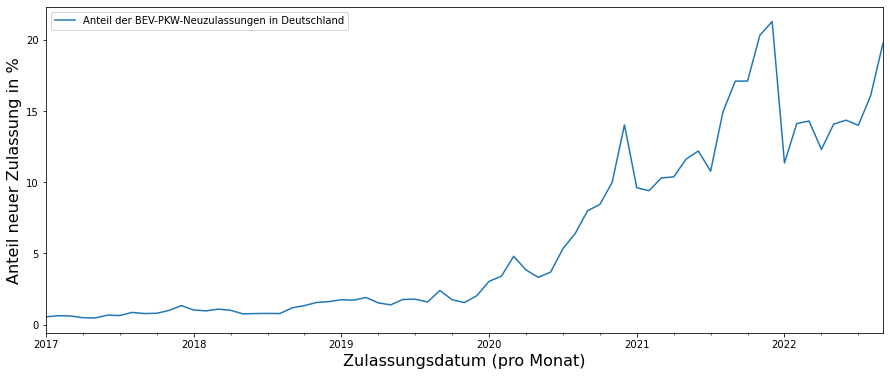

In [14]:
# Visualizing the dataset
df.rename(columns={'Batterieelektrisch': 'Anteil der BEV-PKW-Neuzulassungen in Deutschland'}, inplace=True)
df.plot(figsize=(15,6))
#plt.title('Batterieelektrische PKW-Neuzulassungen in Deutschland\n', size=20)
plt.xlabel('Zulassungsdatum (pro Monat)' ,size=16)
plt.ylabel('Anteil neuer Zulassung in %' ,size=16)
plt.show()

## Stationarity Test
A time series is <em>stationary</em> if the mean and variance are fixed between any two equidistant points. That is, no matter where you take your observations, the results should be the same. A times series that shows seasonality is <em>not</em> stationary.

A test for stationarity usually involves a <a href='https://en.wikipedia.org/wiki/Unit_root_test'>unit root</a> hypothesis test, where the null hypothesis $H_0$ is that the series is <em>nonstationary</em>, and contains a unit root. The alternate hypothesis $H_1$ supports stationarity. The <a href='https://en.wikipedia.org/wiki/Augmented_Dickey-Fuller_test'>augmented Dickey-Fuller</a> and <a href='https://en.wikipedia.org/wiki/KPSS_test'>Kwiatkowski-Phillips-Schmidt-Shin</a> tests are stationarity tests.


### Augmented Dickey-Fuller Test
To determine whether a series is stationary we can use the <a href='https://en.wikipedia.org/wiki/Augmented_Dickey-Fuller_test'>augmented Dickey-Fuller Test</a>. In this test the null hypothesis states that $\phi = 1$ (this is also called a unit test). The test returns several statistics we'll see in a moment. Our focus is on the p-value. A small p-value ($p<0.05$) indicates strong evidence against the null hypothesis.

To find out what these values represent we can run <tt>help(adfuller)</tt>. Then we can add our own labels:

In [15]:
# Method 2: Creating a function for Augmented Dicky-Fuller Test
# This would be usefull if we are to use it in more occassions.
def adfuller_stationarity_test(time_series_data, title=''):
    """
    Pass in a time series input-data and an optional title for input data, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    print('–'*50)
    result = adfuller(time_series_data.dropna(),autolag='AIC') # .dropna() handles differenced data

    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val

    print(out.to_string())          # .to_string() removes the line "dtype: float64"

    if result[1] <= 0.05:
        print('–'*50)
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")

    else:
        print('–'*50)
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")
    # Plotting the DataFrame
    #time_series_data.plot()

In [16]:
adfuller_stationarity_test(df)

Augmented Dickey-Fuller Test: 
––––––––––––––––––––––––––––––––––––––––––––––––––
ADF test statistic       0.819266
p-value                  0.991941
# lags used              8.000000
# observations          60.000000
critical value (1%)     -3.544369
critical value (5%)     -2.911073
critical value (10%)    -2.593190
––––––––––––––––––––––––––––––––––––––––––––––––––
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


## Seasonal Decomposition
Statsmodels provides a <em>seasonal decomposition</em> tool we can use to separate out the different components. This lets us see quickly and visually what each component contributes to the overall behavior.


We apply an <strong>additive</strong> model when it seems that the trend is more linear and the seasonality and trend components seem to be constant over time (e.g. every year we add 10,000 passengers).<br>
A <strong>multiplicative</strong> model is more appropriate when we are increasing (or decreasing) at a non-linear rate (e.g. each year we double the PKW-Allowances).

In [17]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6

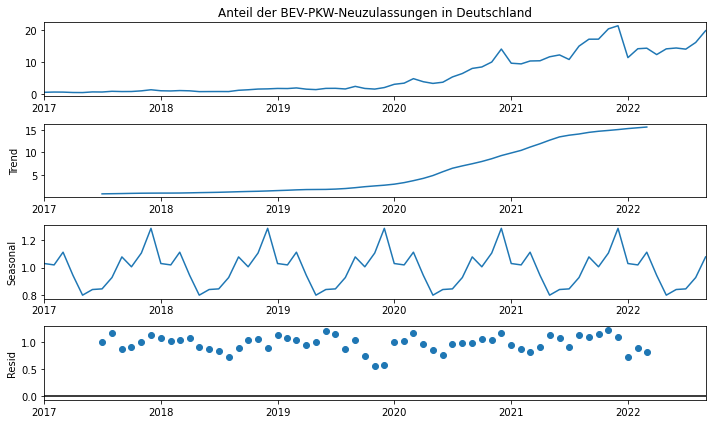

In [18]:
# ETS: Error, Trend, Seasonlity
ETS_seasonal_decomposition = seasonal_decompose(df['Anteil der BEV-PKW-Neuzulassungen in Deutschland'], model='multiplicative')  # model='add' also works
ETS_seasonal_decomposition.plot();

As Seen above there is :
* upward **Trend**
* **Seasonality**
* **Residual**



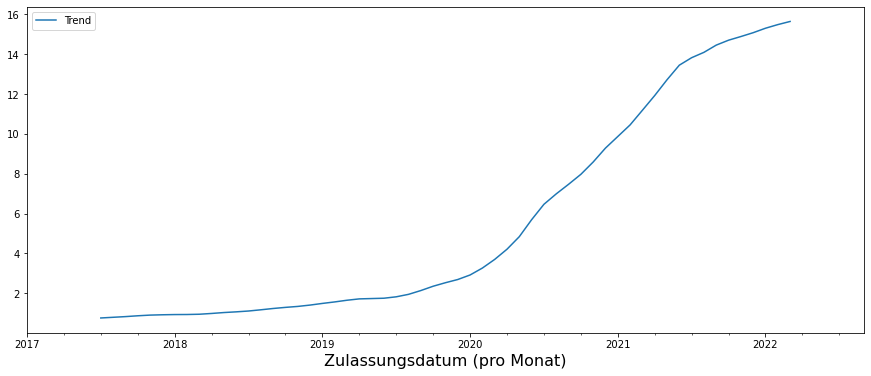

In [19]:
# Visualize Trend in Dataset
ETS_seasonal_decomposition.trend.rename("Trend").plot(figsize=(15,6))
plt.xlabel('Zulassungsdatum (pro Monat)',size=16)
#plt.ylabel('Anteil neuer Zulassung in %', size=16)
plt.legend(loc=2)
plt.show()

In [20]:
# Check only values of the trend
ETS_seasonal_decomposition.trend.values

array([        nan,         nan,         nan,         nan,         nan,
               nan,  0.75666667,  0.79083333,  0.825     ,  0.86666667,
        0.90041667,  0.91708333,  0.92791667,  0.93083333,  0.94416667,
        0.98333333,  1.02916667,  1.06416667,  1.10583333,  1.16708333,
        1.2325    ,  1.28833333,  1.33625   ,  1.40375   ,  1.48666667,
        1.56208333,  1.64666667,  1.71458333,  1.73125   ,  1.74791667,
        1.81875   ,  1.9425    ,  2.13291667,  2.34958333,  2.52625   ,
        2.68666667,  2.91416667,  3.26208333,  3.69541667,  4.20708333,
        4.83708333,  5.68791667,  6.46125   ,  6.985     ,  7.46416667,
        7.96541667,  8.58291667,  9.2825    ,  9.86333333, 10.44541667,
       11.18      , 11.92      , 12.71125   , 13.44416667, 13.81916667,
       14.08833333, 14.45125   , 14.69791667, 14.88125   , 15.07416667,
       15.29833333, 15.48      , 15.63791667,         nan,         nan,
               nan,         nan,         nan,         nan])

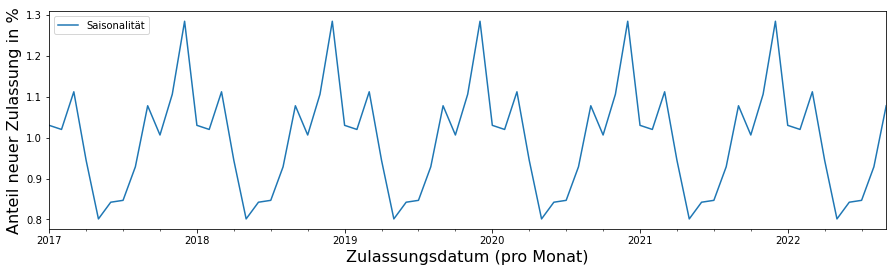

In [21]:
# Visualize the seasonality in dataset
ETS_seasonal_decomposition.seasonal.rename("Saisonalität").plot(figsize=(15,4))
plt.xlabel('Zulassungsdatum (pro Monat)',size=16)
plt.ylabel('Anteil neuer Zulassung in %', size=16)
plt.legend(loc=2)
plt.show()

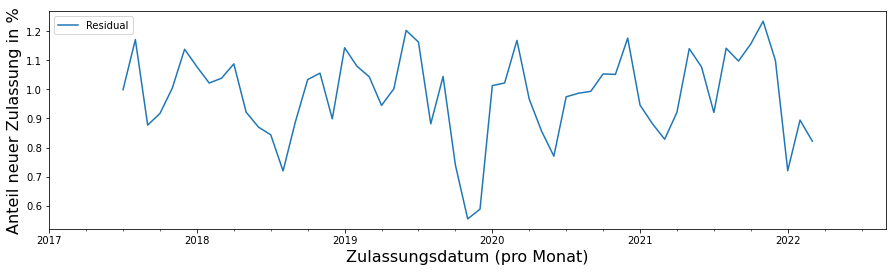

In [22]:
# Histogram of Residuals
# ETS_seasonal_decomposition.resid.plot()
ETS_seasonal_decomposition.resid.rename("Residual").plot(figsize=(15,4))
plt.xlabel('Zulassungsdatum (pro Monat)',size=16)
plt.ylabel('Anteil neuer Zulassung in %', size=16)
plt.legend(loc=2)
plt.show()

## Exposing Seasonality: Monthly and Quarter
Statsmodels has two plotting functions that group data by month and by quarter.

**Note:** If the data appears as months, you should employ <em>resampling</em> with an aggregate function before running a quarter plot. These plots return a <tt>matplotlib.Figure</tt> object.

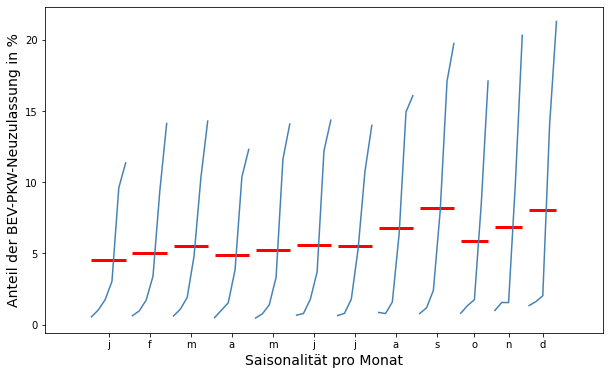

In [23]:
# Note: add a semicolon to prevent two plots being displayed in jupyter
month_plot(df);

rcParams['figure.figsize'] = 10, 6

for i in range(12):
    plt.gca().get_lines()[i].set_color("steelblue")
plt.xlabel('Saisonalität pro Monat', size=14)
plt.ylabel('Anteil der BEV-PKW-Neuzulassung in %', size=14)
plt.show()




As we can see the months of November and December have higher seasonality and June and July has the lowest seasonality.

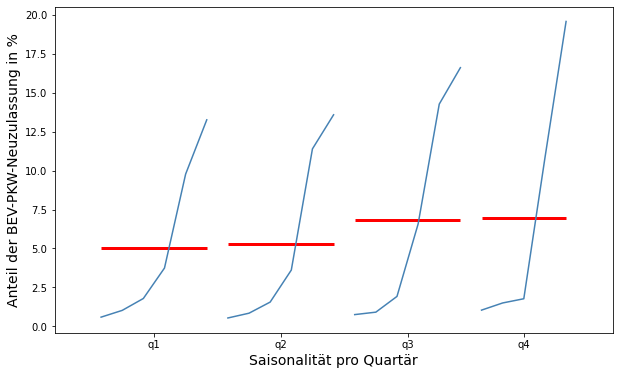

In [24]:
# First: Resamole Data to Quartly
quarter_df = df.resample(rule='Q').mean()
# Plot Quartly Visualization
quarter_plot(quarter_df);

rcParams['figure.figsize'] = 8, 5

for i in range(4):
    plt.gca().get_lines()[i].set_color("steelblue")
plt.xlabel('Saisonalität pro Quartär', size=14)
plt.ylabel('Anteil der BEV-PKW-Neuzulassung in %', size=14)
plt.show()

Q4 (Oct., Nov. Dec.) has higher seasonality.

## Auto Correlation Function (ACF)
Plotting the stationary <strong>PKW-Neuzulassungen</strong> dataset:

For Moving Average Model (MA) it is best to use ACF-Plot and for Autoregressive Model (AR) PACF is the suitable.
Plotting the magnitude of the autocorrelations over the first few (20) lags can say a lot about a time series.

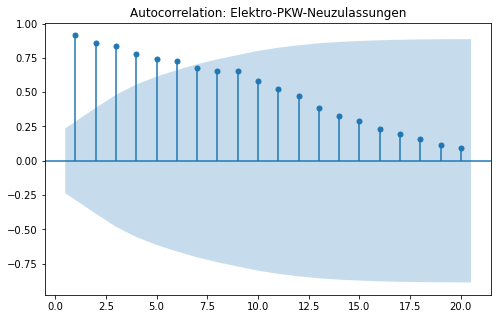

In [25]:
title = 'Autocorrelation: Elektro-PKW-Neuzulassungen'
lags = 20
plot_acf(df,title=title,lags=lags, zero=False);
# Zero = False : Because don't want to see an autocorrelation of the first value against itself

This plot indicates non-stationary data, as there are a large number of lags before ACF values drop off.
Shows 5 significant Lags

## Particial Auto-Corelation Function (PACF)
**PACF Plots**
Partial autocorrelations work best with **stationary data** and **AR-Model**.
Let's check again the same dataset:

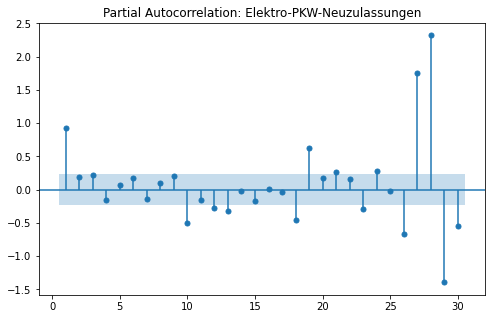

In [26]:
title = 'Partial Autocorrelation: Elektro-PKW-Neuzulassungen' # Title for plot
lags = 30   # Number of lags
plot_pacf(df,title=title,lags=lags, zero=False);   # Zero = False will avoid plotting the value against itself

## Normalisation:
Do we need to normalise the dataset for better prediction accuracy?
[Taj]: I Should try it out with SARIMAX if it really does.
-> I tried, but it doesn't help improve accuracy or decrease model errors.

## Standarisation
**Sklearn**


## Polynomial Changes

# Train Test Split

* Training Dataset:  92% = 60 Monaten
* Test Dataset:       8% = 6  Monaten

In [27]:
# Setting the training-set size (12 Monat = 17%)
train_size = int(len(df)*0.92)
# Training and Test set
df_train, df_test = df.iloc[:train_size], df.iloc[train_size:]

In [28]:
len(df_test)

6

## Overlapping Checka

In [29]:
# Tail of Training set
print("Training set: Last rows\n", df_train.tail(3))
print('='*40)
# Head of Test set
print("Test set: First rows\n", df_test.head(7))

Training set: Last rows
             Anteil der BEV-PKW-Neuzulassungen in Deutschland
datum                                                       
2022-01-01                                             11.35
2022-02-01                                             14.12
2022-03-01                                             14.29
Test set: First rows
             Anteil der BEV-PKW-Neuzulassungen in Deutschland
datum                                                       
2022-04-01                                             12.30
2022-05-01                                             14.08
2022-06-01                                             14.35
2022-07-01                                             13.99
2022-08-01                                             16.07
2022-09-01                                             19.74


There is no overlapping between train and test sets

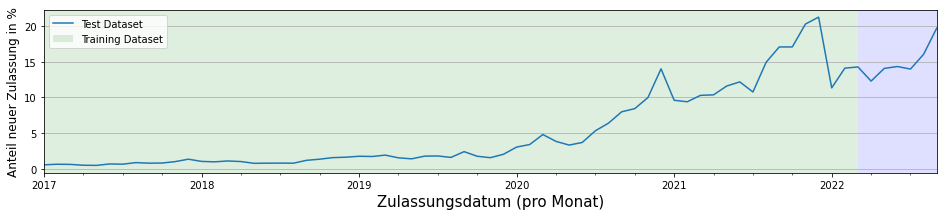

In [30]:
# Visualisation of Train-Test-Split in one Plot
fig, ax = plt.subplots()

df.plot(ax=ax,figsize=(16,3))
#ax.axvline(df_train.index[-1], color="r")  # End of Training dataset
plt.axvspan(df_train.index[0] , df_train.index[-1], facecolor="green", alpha=0.125)
plt.axvspan(df_train.index[-1], df_test.index[-1], facecolor="blue", alpha=0.125)
plt.xlabel('Zulassungsdatum (pro Monat)' ,size=15)
plt.ylabel('Anteil neuer Zulassung in %' ,size=12)
ax.legend(["Test Dataset", "Training Dataset"], loc="upper left")
plt.grid(axis = 'y')
plt.show()

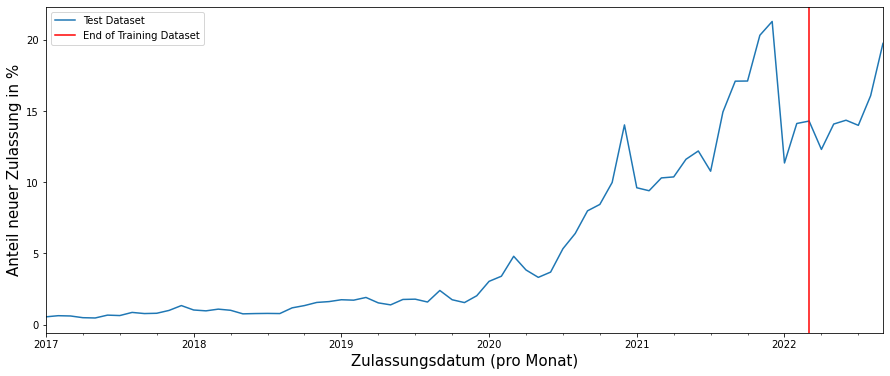

In [31]:
# Visualisation of Train-Test-Split in one Plot
fig, ax = plt.subplots()

df.plot(ax=ax, figsize=(15,6))
ax.axvline(df_train.index[-1], color="r")  # End of Training dataset
ax.legend(["Test Dataset", "End of Training Dataset"], loc="upper left")
plt.xlabel('Zulassungsdatum (pro Monat)' ,size=15)
plt.ylabel('Anteil neuer Zulassung in %' ,size=15)
plt.show()

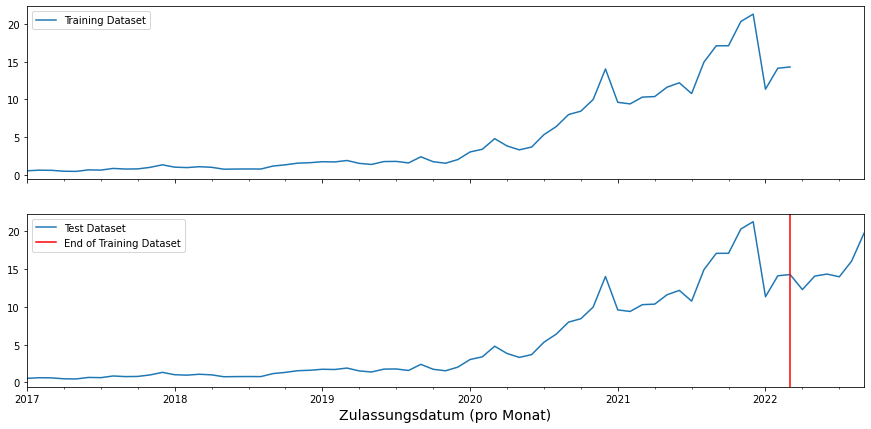

In [32]:
# Visualisation of Train-Test-Split in one Plot
fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(15,7))

df_train.plot(ax=ax[0])
ax[0].legend(["Training Dataset"], loc="upper left")

df.plot(ax=ax[1])
ax[1].axvline(df_train.index[-1], color="r")  # End of Training dataset
ax[1].legend(["Test Dataset", "End of Training Dataset"], loc="upper left")
plt.xlabel('Zulassungsdatum (pro Monat)' ,size=14)
plt.show()

# SARIMA Model Training

In [126]:
sarimax_model = SARIMAX(df_train,                           # Training Dataset
                        order=(3,2,1),                      # p,d,q order
                        seasonal_order= (1,0,0,12),         # P,D,Q order
                        freq='MS',                          # Data Frequency
                        n_jobs=-1,                          # Num of CPUs, -1 mean all CPUs
                        )
# Fitting SARIMA Model
results = sarimax_model.fit()
# Outputs Model Summary
print(results.summary());

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.96680D+00    |proj g|=  1.58996D-01

At iterate    5    f=  1.88040D+00    |proj g|=  9.08572D-02

At iterate   10    f=  1.83405D+00    |proj g|=  7.13357D-02

At iterate   15    f=  1.82073D+00    |proj g|=  5.42023D-03

At iterate   20    f=  1.81963D+00    |proj g|=  1.42476D-03

At iterate   25    f=  1.81947D+00    |proj g|=  1.54070D-03

At iterate   30    f=  1.81945D+00    |proj g|=  5.26378D-04

At iterate   35    f=  1.81945D+00    |proj g|=  2.35154D-04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     39     57      1     0     0   9.597D-05   1.819D+00
  F =   1.8194519026374432     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                              SARIMAX Results                                               
Dep. Variable:     Anteil der BEV-PKW-Neuzulassungen in Deutschland   No. Observations:                   63
Model:                              SARIMAX(3, 2, 1)x(1, 0, [], 12)   Log Likelihood                -114.625
Date:                                              Sun, 06 Nov 2022   AIC                       


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


# Model Evaluation


In [127]:
# General format to obtain predictions
start=len(df_train)
end=len(df_train) + len(df_test) -1
pred = results.predict(start=start, end=end, dynamic=False , typ='level').rename('SARIMAX (3,2,1)x(1,0,0,12)  Forecast')
pred

2022-04-01    12.836872
2022-05-01    14.372532
2022-06-01    14.899536
2022-07-01    13.773070
2022-08-01    16.386376
2022-09-01    17.770203
Freq: MS, Name: SARIMAX (3,2,1)x(1,0,0,12)  Forecast, dtype: float64

Passing **<tt>dynamic=False</tt>** means that forecasts at each point are generated using the full history up to that point (all lagged values).

Passing **<tt>typ='levels'</tt>** predicts the levels of the original endogenous variables. If we'd used the default <tt>typ='linear'</tt> we would have seen linear predictions in terms of the differenced endogenous variables.

Passing **<tt>rename('SARIMA Predictions')</tt>** creates a name for our predicted varaible. This is helpful when we plot the data and shows up in 'Legend'

For more information on these arguments visit https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMAResults.predict.html

In [128]:
# Comparison: observation vs. predicted values
for i in range(len(pred)):
    print(f"predicted = {pred[i]:<11.6} \t expected = {df_test['Anteil der BEV-PKW-Neuzulassungen in Deutschland'][i]}")

predicted = 12.8369     	 expected = 12.3
predicted = 14.3725     	 expected = 14.08
predicted = 14.8995     	 expected = 14.35
predicted = 13.7731     	 expected = 13.99
predicted = 16.3864     	 expected = 16.07
predicted = 17.7702     	 expected = 19.74


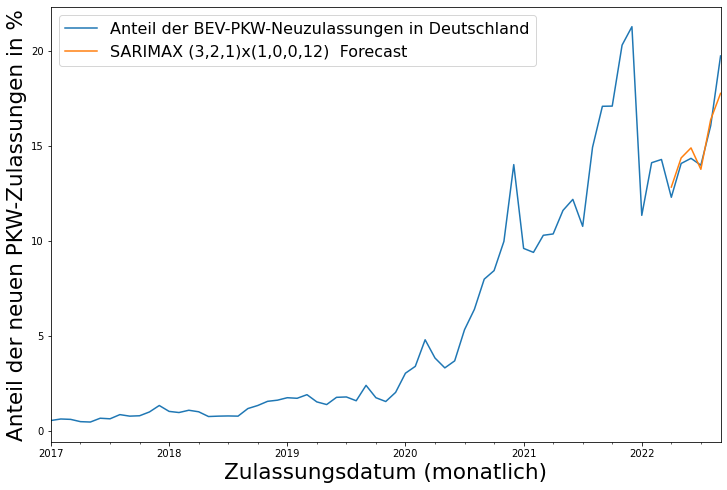

In [129]:
# Visualisation of Test-Dataset vs. Predicted Values.
df.plot(legend=True)
pred.plot(legend=True, figsize=(12,8))
#plt.title("Forecasting: Test Dataset v.s. Predicted Values\n", size=24)
plt.xlabel("Zulassungsdatum (monatlich)", size=21.5)
plt.ylabel("Anteil der neuen PKW-Zulassungen in %", size=21.5)
plt.legend(fontsize=16)
plt.show()

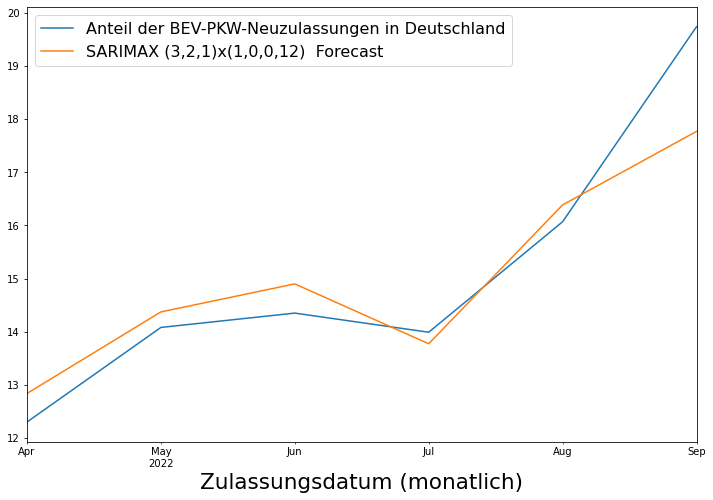

In [130]:
# Visualisation of Test-Dataset vs. Predicted Values.
df.iloc[-len(pred):].plot(legend=True)
pred.plot(legend=True, figsize=(12,8))
#plt.title("Forecasting: Test Dataset v.s. Predicted Values\n", size=24)
plt.xlabel("Zulassungsdatum (monatlich)", size=21.5)
#plt.ylabel("Anteil der neuen PKW-Zulassungen in %")
plt.legend(fontsize=16)
plt.show()

### RMSE Error

In [131]:
RMSE = np.sqrt(mean_squared_error(df_test, pred))
print(f'RMSE Error  = \t {RMSE:11.4}')

RMSE Error  = 	      0.8853


In [132]:
# Checking mean values of Test Dataset v.s. Predicted values:
print("Average value of test-set:  \t", round(df_test.values.mean(), 3))
print("Average value of prediction:\t", round(pred.mean(), 3))

Average value of test-set:  	 15.088
Average value of prediction:	 15.006


# Hyperparameter Optimization (HPO)
## Auto-Arima

In [57]:
auto_arima_deep = auto_arima(df,            # Name of variable we are predicting
                             seasonal=True,
                             m = 12,        # Seasonal cycle length
                             max_order = 200,  # Maximum amount of variables to be used in the regression (p + q). "None" allows model be more flexible and to choose any combination.
                             max_p = 10,    # Maximum AR components (Highest non-seasonal AR order)
                             max_q = 10,    # Maximum MA components
                             max_d = 10,    # Maximum Integrations
                             max_P = 10,    # Maximum Seasonal AR components
                             max_Q = 10,    # Maximum Seasonal MA components
                             max_D = 10,    # Maximum Seasonal Integrations
                             start_p = 0,      # Minimum AR components (Highest non-seasonal AR order)
                             start_q = 0,      # Minimum MA components
                             start_P = 0,      # Minimum Seasonal AR components
                             start_Q = 0,      # Minimum Seasonal MA components
                             maxiter = 100, # Maximum iterations we're giving the model to converge the coefficients (becomes harder as the order increases)
                             alpha = 0.05,  # Level of significance, default is 5%, which we should be using most of the time
                             n_jobs = -1,   # How many models to fit at a time (-1 indicates "as many as possible")
                             information_criterion = 'aic', # 'aic', 'aicc', 'bic', 'hqic', 'oob'
                             out_of_sample_size = int(len(df)*0.20))    # validates the model selection (pass the entire dataset, and set 20% to be the out_of_sample_size)

print(auto_arima_deep.summary())            # To show model summary

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                   69
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 12)   Log Likelihood                -104.906
Date:                             Sun, 06 Nov 2022   AIC                            213.811
Time:                                     12:51:55   BIC                            217.862
Sample:                                          0   HQIC                           215.382
                                              - 69                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2427      0.080     -3.030      0.002      -0.400      -0.086
sigma2         2.4785      

   **Information Criterions:**
* AIC: Akaike Information Criterion
* AICC: Corrected Akaike Information Criterion
* BIC: Bayesian Information Criterion
* HQIC: Hannan-Quinn Information Criterion
* OBB: Out of bag "--for validation scoring--respectively"

## Grid Search

In [ ]:
# Keep record of grid search time
start_time = time.time()

# Define the p, d and q parameters to take any value between 0 and 4 (exclusive)
p = d = q = range(0, 5)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
# Generate all different combinations of seasonal p, q and q triplets
# Note: here is 12 in the 's' position as we have monthly data
PDQs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

# Define function
def sarima_gridsearch(df_train, pdq, PDQs, freq='MS', maxiter=100):
    '''
    Input:
        df_train : your time series data
        pdq : ARIMA combinations from above
        PDQs : seasonal ARIMA combinations from above
        maxiter : number of iterations, increase if your model isn't converging
        frequency : default='M' for month. e.g. 'D' for day, 'H' for hour, 'Y' for year.
    Return:
        Prints out the parameter combinations
        Returns dataframe of parameter combinations ranked by AIC
    '''

    # Run a grid search with pdq and seasonal PDQs parameters and get the best AIC value
    results = []
    for pdq_comb in pdq:
        for PDQs_combs in PDQs:
            try:
                sarimax_model=SARIMAX(df_train,  # This is the target variable in dataset
                              order=pdq_comb,
                              seasonal_order=PDQs_combs,
                              freq=freq)
                result = sarimax_model.fit(disp=False, maxiter=maxiter)
                pred = result.predict(start=len(df_train), end=(len(df_train) + len(df_test) -1), dynamic=False , typ='level').rename(f'SARIMAX {pdq_comb}x{PDQs_combs}: Predictions')
                RMSE = np.sqrt(mean_squared_error(df_test, pred))
                results.append([pdq_comb, PDQs_combs, round(result.aic, 5), round(RMSE, 5)])
                print(f'\n{len(results)}  of  15625 Models \t SARIMAX {pdq_comb}x{PDQs_combs} \t AIC Criterion: {round(result.aic, 5)} \t RMSE: {round(RMSE, 5)}')
            except:
                continue
    # Convert the results into dataframe
    results_df = pd.DataFrame(results, columns=['pdq', 'seasonal_PDQs', 'AIC_Error', 'RMSE'])
    # Sort the DataFrame according to RMSE
    results_df = results_df.sort_values(by=['RMSE'],ascending=True)
    # Returning grid search result as a DataFrame
    return results_df

# Executing grid search function
gridsearch = sarima_gridsearch(df_train, pdq, PDQs, freq='MS')
# Saving grid search result as CSV-File
gridsearch.to_csv('/Path/To/Dataset/01_SARIMA_gridsearch_RMSE_6MonthsForecast_16525_Models_ParamsMax4_V1.csv')
# Keep record of grid search time
print(f"\nTime spent for grid search with SARIMAX (Minutes):\t{round((time.time() - start_time)/60, 2)}")

# Checking the first 15 results
gridsearch.head(15)


15063  of  15625 Models 	 SARIMAX (4, 4, 4)x(4, 2, 4, 12) 	 AIC Criterion: 204.46196 	 RMSE: 3.29067

15064  of  15625 Models 	 SARIMAX (4, 4, 4)x(4, 3, 0, 12) 	 AIC Criterion: 162.43769 	 RMSE: 25.30431

15065  of  15625 Models 	 SARIMAX (4, 4, 4)x(4, 3, 1, 12) 	 AIC Criterion: 164.15063 	 RMSE: 18.6425

15066  of  15625 Models 	 SARIMAX (4, 4, 4)x(4, 3, 2, 12) 	 AIC Criterion: 165.76295 	 RMSE: 18.69981

15067  of  15625 Models 	 SARIMAX (4, 4, 4)x(4, 3, 3, 12) 	 AIC Criterion: 159.49571 	 RMSE: 12.57156

15068  of  15625 Models 	 SARIMAX (4, 4, 4)x(4, 3, 4, 12) 	 AIC Criterion: 162.41201 	 RMSE: 7.38411

15069  of  15625 Models 	 SARIMAX (4, 4, 4)x(4, 4, 0, 12) 	 AIC Criterion: 105.29692 	 RMSE: 106.09092

15070  of  15625 Models 	 SARIMAX (4, 4, 4)x(4, 4, 1, 12) 	 AIC Criterion: 111.88538 	 RMSE: 60.64704

15071  of  15625 Models 	 SARIMAX (4, 4, 4)x(4, 4, 2, 12) 	 AIC Criterion: 110.49191 	 RMSE: 117.5177

15072  of  15625 Models 	 SARIMAX (4, 4, 4)x(4, 4, 3, 12) 	 AIC Criterion:

,pdq,seasonal_PDQs,AIC_Error,RMSE
10397,"(3, 2, 1)","(1, 0, 0, 12)",241.25093,0.88513
10522,"(3, 2, 2)","(1, 0, 0, 12)",242.75074,0.89734
7500,"(2, 2, 2)","(1, 0, 0, 12)",241.15154,0.94438
9922,"(3, 1, 2)","(1, 0, 0, 12)",242.78117,0.99055
12192,"(4, 0, 1)","(0, 1, 0, 12)",203.82280,0.99474
6776,"(2, 1, 1)","(1, 0, 0, 12)",238.89911,0.99492
12067,"(4, 0, 0)","(0, 1, 0, 12)",202.00837,1.00047
174,"(0, 0, 1)","(2, 0, 0, 12)",322.37685,1.01104
9177,"(3, 0, 1)","(0, 1, 0, 12)",201.83074,1.01335
6651,"(2, 1, 0)","(1, 0, 0, 12)",237.79340,1.06700


In [ ]:
# Load back the saved Grid Search:
#gridsearch_loadback=pd.read_csv('Path/To/Load/01_SARIMA_gridsearch_RMSE_6MonthsForecast_16525_Models_ParamsMax4_V1.csv')
#gridsearch_loadback.head()

## Optuna HPO
Optuna has 2 parts:

   * **Objective function:** To define which params and how the model should be trained as well as based on which error metric should Optuna optimize all process.
   * **Trail:** To specify how many times optuna should run to find the best parameter-combination for DeepAR Model.

In [58]:
# Optuna's Objective Function:

class SarimaxTuningObjective:
    def __init__(self, df_train, df_test, freq='MS', maxiter=100):
        """
        df_train: Training Dataset
        df_test: Test Dataset
        freq: Data Frequency
        maxiter: Max. num of iteration
        """

        self.df_train = df_train
        self.df_test = df_test
        self.freq = freq
        self.maxiter = maxiter

    """
    get_params() Function: Sets types and size of all parameters for HPO process with Optuna:
         trial.suggest_int():           Used for params that take integers values.
         trial.suggest_float():         Used for params that take float values.
         trial.suggest_categorical()    Used for params that take categorical values.
    """
    def get_params(self, trial) -> dict:
        return {
            "p": trial.suggest_int("p", 0, 4),
            "d": trial.suggest_int("d", 0, 4),
            "q": trial.suggest_int("q", 0, 4),
            "P": trial.suggest_int("P", 0, 4),
            "D": trial.suggest_int("D", 0, 4),
            "Q": trial.suggest_int("Q", 0, 4),
        }

    """
    __call__() Function:
        Takes all the specified params,
        Uses training and test datsets,
        trains SARIMA Model,
        then return the RMSE Error accordingly
    """
    def __call__(self, trial):
        params = self.get_params(trial)
        try:
            sarimax_model = SARIMAX(
                df_train,  # this is your time series you will input
                order=(params["p"],params["d"],params["q"]),
                seasonal_order=(params["P"],params["D"],params["Q"],12),
                freq=self.freq)
            result = sarimax_model.fit(disp=False, maxiter=self.maxiter)
            pred = result.predict(start=len(self.df_train), end=(len(self.df_train) + len(self.df_test) -1), dynamic=False , typ='level')
            RMSE = np.sqrt(mean_squared_error(self.df_test, pred))
            # Returns RMSE metric
            return RMSE
        except:
            pass


Optuna's Execution for HPO:

In [6]:
#optuna.logging.set_verbosity(optuna.logging.WARNING)                                # It basically supresses the level of verbosity.

start_time = time.time()                                                            # Keep record of time HPO takes
# As default Optuna uses TPE, but we can also specify another Sampler.

from optuna.samplers import TPESampler
sampler = TPESampler(seed=7)   # Make the sampler behave in a deterministic way.
study = optuna.create_study(study_name='SARIMA Model (Univariate Zeitreihenanalyse)',      # Name for current Optuna HPO
                            direction="minimize"                                    # Purpose of Param-Tuning -> to minimize the Model-Error
                            )
study.optimize(
    SarimaxTuningObjective(df_train,df_test,freq='MS'),
                            n_trials=100)           # Num of Trails to search for

# Outputs num of Trails finished
print(f"Number of finished trials:\t{len(study.trials)}")
# Shows best trail value
trial = study.best_trial
print(f"\nBest trial's Value:\t\t{trial.value}")
# Shows params used for best trials
print("\nParams: ")
for key, value in trial.params.items():
    print(f" {key}:\t{value}")
# Shows time spent for current Optuna HPO Proces (in minutes)
print(f"\nTime spent for HPO (Minutes):\t{round((time.time() - start_time)/60, 2)}")

Number of finished trials:	100

Best trial's Value:		1.2609993895180844

Params: 
 p:	3
 d:	2
 q:	2
 P:	1
 D:	0
 Q:	1


#### Saving Optuna HPO Study

In [ ]:
# Saving Optuna HPO Study
joblib.dump(study, "/Path/To/Dataset/01_SARIMA_Optuna_HPO_6MonthsForecast_ParamsMax4_V1.pkl")

# To Load Optuna Study
#study = joblib.load("/Path/To/Dataset//01_SARIMA_Optuna_HPO_6MonthsForecast_ParamsMax4_V1.pkl")
#print(f"Number of finished trials:\t{len(study.trials)}")
#trial = study.best_trial
#print(f"\nBest trial's Value:\t\t{trial.value}")
#print("\nParams: ")
#for key, value in trial.params.items():
#    print(f" {key}:\t{value}")

Optuna provides nice visualisation for each study (HPO Process with Optuna). To visualise each of these functionalites, we need import Optuna based Plotting Methods:

In [18]:
# Returns Optuna's Tuning results as a DataFrame
optuna_result = study.trials_dataframe()
optuna_result

,number,value,datetime_start,datetime_complete,duration,params_D,params_P,params_Q,params_d,params_p,params_q,state
0,0,2.629249,2022-10-30 15:54:56.448984,2022-10-30 15:54:57.897243,0 days 00:00:01.448259,3,3,0,2,2,1,COMPLETE
1,1,33.278018,2022-10-30 15:54:57.898109,2022-10-30 15:54:58.005604,0 days 00:00:00.107495,0,1,0,4,1,1,COMPLETE
2,2,4.440790,2022-10-30 15:54:58.006591,2022-10-30 15:54:59.256056,0 days 00:00:01.249465,2,4,2,0,0,3,COMPLETE
3,3,2.023982,2022-10-30 15:54:59.257011,2022-10-30 15:55:00.776600,0 days 00:00:01.519589,1,4,3,0,0,4,COMPLETE
4,4,20.392502,2022-10-30 15:55:00.777795,2022-10-30 15:55:01.493011,0 days 00:00:00.715216,1,4,4,3,2,0,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,1.260999,2022-10-30 15:57:32.383424,2022-10-30 15:57:32.927439,0 days 00:00:00.544015,0,1,1,2,3,2,COMPLETE
96,96,1.260999,2022-10-30 15:57:32.928399,2022-10-30 15:57:33.471311,0 days 00:00:00.542912,0,1,1,2,3,2,COMPLETE
97,97,1.260999,2022-10-30 15:57:33.472581,2022-10-30 15:57:34.014838,0 days 00:00:00.542257,0,1,1,2,3,2,COMPLETE
98,98,1.260999,2022-10-30 15:57:34.015751,2022-10-30 15:57:34.554471,0 days 00:00:00.538720,0,1,1,2,3,2,COMPLETE


In [19]:
optuna_result.values

array([[0, 2.629249338922649, Timestamp('2022-10-30 15:54:56.448984'),
        ..., 2, 1, 'COMPLETE'],
       [1, 33.27801839995153, Timestamp('2022-10-30 15:54:57.898109'),
        ..., 1, 1, 'COMPLETE'],
       [2, 4.440790427718056, Timestamp('2022-10-30 15:54:58.006591'),
        ..., 0, 3, 'COMPLETE'],
       ...,
       [97, 1.2609993895180844, Timestamp('2022-10-30 15:57:33.472581'),
        ..., 3, 2, 'COMPLETE'],
       [98, 1.2609993895180844, Timestamp('2022-10-30 15:57:34.015751'),
        ..., 3, 2, 'COMPLETE'],
       [99, 7.6253893764094, Timestamp('2022-10-30 15:57:34.555583'),
        ..., 3, 2, 'COMPLETE']], dtype=object)

In [20]:
# Sorting Optuna's results according to its values 
# This allows us to see all the lowest errors first
optuna_result = optuna_result.sort_values(by='value', ascending=True)
optuna_result.head()

,number,value,datetime_start,datetime_complete,duration,params_D,params_P,params_Q,params_d,params_p,params_q,state
75,75,1.260999,2022-10-30 15:57:17.275480,2022-10-30 15:57:17.863824,0 days 00:00:00.588344,0,1,1,2,3,2,COMPLETE
22,22,1.260999,2022-10-30 15:55:39.316827,2022-10-30 15:55:39.934272,0 days 00:00:00.617445,0,1,1,2,3,2,COMPLETE
85,85,1.260999,2022-10-30 15:57:26.471895,2022-10-30 15:57:27.205221,0 days 00:00:00.733326,0,1,1,2,3,2,COMPLETE
84,84,1.260999,2022-10-30 15:57:25.719372,2022-10-30 15:57:26.470686,0 days 00:00:00.751314,0,1,1,2,3,2,COMPLETE
83,83,1.260999,2022-10-30 15:57:25.088786,2022-10-30 15:57:25.718320,0 days 00:00:00.629534,0,1,1,2,3,2,COMPLETE


In [21]:
# Visualising the optimizsation history. It shows how (Optuna's) Error decreased over time.
# https://optuna.readthedocs.io/en/stable/reference/visualization/generated/optuna.visualization.plot_optimization_history.html#optuna.visualization.plot_optimization_history
from optuna.visualization import plot_optimization_history
plot_optimization_history(study)

In [36]:
# Visualize parameter importances
# More info: https://optuna.readthedocs.io/en/stable/reference/visualization/generated/optuna.visualization.plot_param_importances.html#optuna.visualization.plot_param_importances
from optuna.visualization import plot_param_importances
plot_param_importances(study)

In [28]:
# Check which hyperparameters are affecting the trial duration with hyperparameter importance.
optuna.visualization.plot_param_importances(
    study, target=lambda t: t.duration.total_seconds(), target_name="duration"
)

In [29]:
# Visualize high-dimensional parameter relationships.
# https://optuna.readthedocs.io/en/stable/reference/visualization/generated/optuna.visualization.plot_parallel_coordinate.html#optuna.visualization.plot_parallel_coordinate
from optuna.visualization import plot_parallel_coordinate
plot_parallel_coordinate(study)

In [30]:
# Select specific parameters to visualize.
plot_parallel_coordinate(study, params=["d", "q"])

In [31]:
# Visualize hyperparameter relationships
# More info: https://optuna.readthedocs.io/en/stable/reference/visualization/generated/optuna.visualization.plot_contour.html#optuna.visualization.plot_contour
from optuna.visualization import plot_contour
plot_contour(study)

In [32]:
# Visualize specific hyperparameter relationships
plot_contour(study, params=["d", "q"])

In [33]:
# Visualize individual hyperparameters as slice plot.
# More info: https://optuna.readthedocs.io/en/stable/reference/visualization/generated/optuna.visualization.plot_slice.html#optuna.visualization.plot_slice
from optuna.visualization import plot_slice
plot_slice(study)

In [34]:
# Select specific parameters to visualize as slice plot.
plot_slice(study, params=["p", "D"])

In [ ]:
# Visualize empirical distribution function.
# More info: https://optuna.readthedocs.io/en/stable/reference/visualization/generated/optuna.visualization.plot_edf.html#optuna.visualization.plot_edf
from optuna.visualization import plot_edf
study_sarima = joblib.load("Path/To/Dataset/01_SARIMA_Optuna_HPO_6MonthsForecast_ParamsMax4_V1.pkl")
study_sarima.study_name='SARIMA Model'
study_sarimax = joblib.load("Path/To/Dataset/01_SARIMAX_Optuna_HPO_6MonthsForecast_ParamsMax4_V2.pkl")
study_sarimax.study_name='SARIMAX Model'
study_deepAR_univariate_tsa = joblib.load("Path/To/Dataset/01_DeepAR_Optuna_HPO_6MonthsForecast_With_Seed_V1.pkl")
study_deepAR_univariate_tsa.study_name='DeepAR Model (Univariate)'
study_deepAR_multivariate_tsa = joblib.load("Path/To/Dataset/01_DeepAR_Optuna_HPO_6MonthsForecast_V1.pkl")
study_deepAR_multivariate_tsa.study_name='DeepAR Model (Multivariate)'

plot_edf([study_sarima, study_sarimax, study_deepAR_univariate_tsa, study_deepAR_multivariate_tsa])

# Forecasting
### Re-Train on full Dataset


In [117]:
# Retrain the model on the full data then forecast the future
sarimax_model = SARIMAX(df,
                        order=(3,2,1),                      # p,d,q order
                        seasonal_order= (1,0,0,12),         # P,D,Q order
                        freq='MS'
                        )

results = sarimax_model.fit()
print(results.summary());

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.98208D+00    |proj g|=  2.45355D-01

At iterate    5    f=  1.85087D+00    |proj g|=  5.48527D-02

At iterate   10    f=  1.80204D+00    |proj g|=  2.30118D-02

At iterate   15    f=  1.79871D+00    |proj g|=  1.07031D-02

At iterate   20    f=  1.79830D+00    |proj g|=  1.01812D-03

At iterate   25    f=  1.79826D+00    |proj g|=  4.61453D-04

At iterate   30    f=  1.79826D+00    |proj g|=  2.58853D-04

At iterate   35    f=  1.79825D+00    |proj g|=  2.26562D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

In [118]:
# Alternative Method to check the parameters/coefficients
print(f'Coefficients:\n{results.params}')

Coefficients:
ar.L1      -0.166455
ar.L2      -0.183082
ar.L3       0.155750
ma.L1      -0.999553
ar.S.L12    0.592006
sigma2      2.092740
dtype: float64


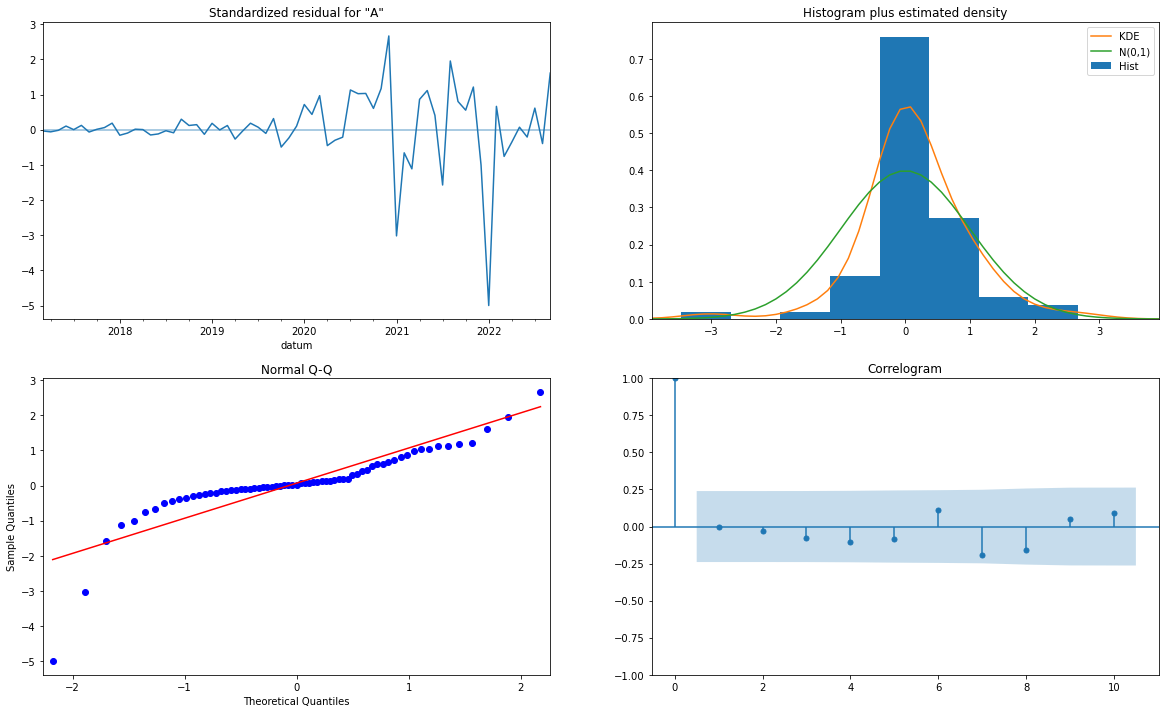

In [119]:
# Model Diagnostics
results.plot_diagnostics(figsize=(20, 12))
plt.show()

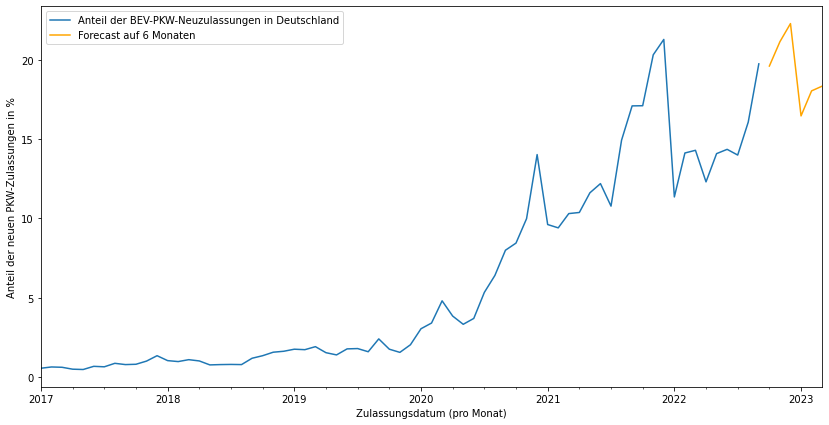

In [120]:
forecast = results.predict(start=len(df),
                           end=len(df) + 5,
                           dynamic=False ,
                           typ='level')

# Visualize the results
df.plot(legend=True)
forecast.plot(legend=True, figsize=(14,7), c='orange')
#plt.title("Forecasting: 12 Monaten", size=24)
plt.xlabel("Zulassungsdatum (pro Monat)")
plt.ylabel("Anteil der neuen PKW-Zulassungen in %", size=21.5)
plt.legend(["Anteil der BEV-PKW-Neuzulassungen in Deutschland", "SARIMAX(4,0,1)x(0,0,3) Forecast"],fontsize=16)
plt.show()

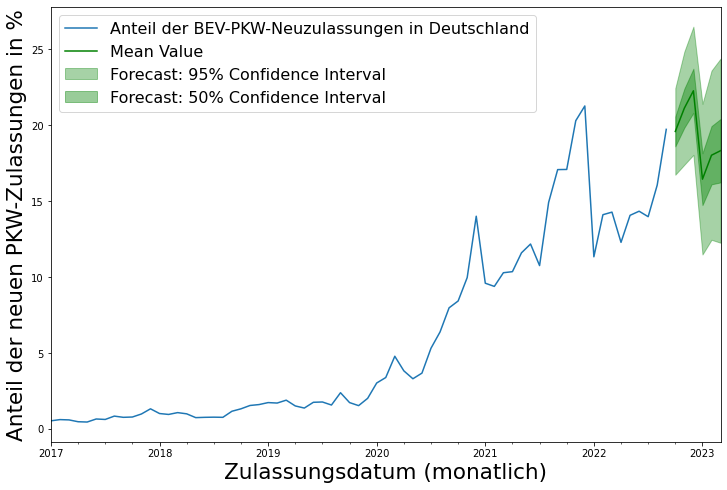

In [121]:
# Confidence Interval Visualization
forecast = results.get_prediction(start=len(df), end=len(df) + 5, dynamic=False , typ='level')
#SARIMAXResults.conf_int, can change alpha,the default alpha = 0.05 returns a 95% confidence interval.
pred_ci_95 = forecast.conf_int(alpha=0.05)
#pred_ci_80 = forecast.conf_int(alpha=0.20)
pred_ci_50 = forecast.conf_int(alpha=0.50)

ax = df.plot(legend=True)
#     print(forecast.predicted_mean)
forecast.predicted_mean.plot(
    ax=ax, 
    #label='Prognose auf 6 Monaten',
    #title="Forecasting: 12 Monaten\n", 
    #alpha=0.5,
    c='green',
    figsize=(12, 8)
    )

ax.fill_between(pred_ci_95.index,
                pred_ci_95.iloc[:, 0],
                pred_ci_95.iloc[:, 1], color='green', alpha=.35)

#ax.fill_between(pred_ci_80.index,
#                pred_ci_80.iloc[:, 0],
#                pred_ci_80.iloc[:, 1], color='green', alpha=.40)#

ax.fill_between(pred_ci_50.index,
                pred_ci_50.iloc[:, 0],
                pred_ci_50.iloc[:, 1], color='green', alpha=.40) 

ax.set_xlabel("Zulassungsdatum (monatlich)", size=21.5)
ax.set_ylabel("Anteil der neuen PKW-Zulassungen in %", size=21.5)
ax.legend(["Anteil der BEV-PKW-Neuzulassungen in Deutschland", "Mean Value", "Forecast: 95% Confidence Interval", "Forecast: 50% Confidence Interval"], loc="upper left", fontsize=16)
plt.show()

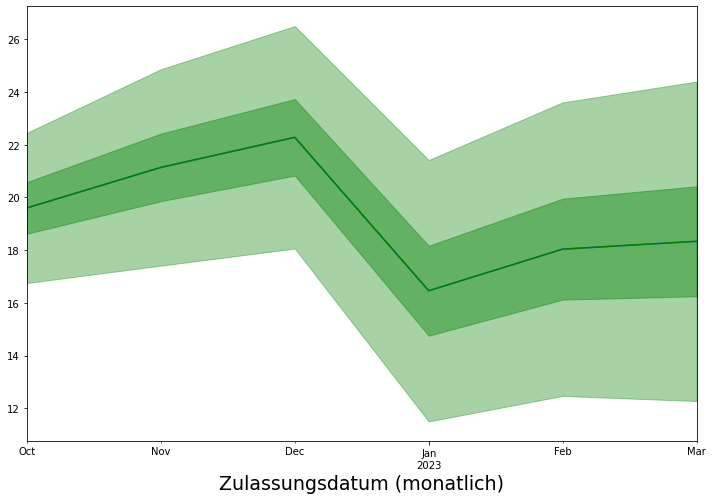

In [122]:
# Confidence Interval Visualization
forecast = results.get_prediction(start=len(df), end=len(df) + 5, dynamic=False , typ='level')
#SARIMAXResults.conf_int, can change alpha,the default alpha = 0.05 returns a 95% confidence interval.
pred_ci_95 = forecast.conf_int(alpha=0.05)
#pred_ci_80 = forecast.conf_int(alpha=0.20)
pred_ci_50 = forecast.conf_int(alpha=0.50)

ax = forecast.predicted_mean.plot(legend=None)
forecast.predicted_mean.plot(
    ax=ax, 
    #label='Prognose auf 6 Monaten',
    #title="Forecasting: 12 Monaten\n", 
    #alpha=0.5,
    c='green',
    figsize=(12, 8)
    )

ax.fill_between(pred_ci_95.index,
                pred_ci_95.iloc[:, 0],
                pred_ci_95.iloc[:, 1], color='green', alpha=.35)

#ax.fill_between(pred_ci_80.index,
#                pred_ci_80.iloc[:, 0],
#                pred_ci_80.iloc[:, 1], color='green', alpha=.40)#

ax.fill_between(pred_ci_50.index,
                pred_ci_50.iloc[:, 0],
                pred_ci_50.iloc[:, 1], color='green', alpha=.40) 
#ax.set_ylim(11, 31)
ax.set_xlabel("Zulassungsdatum (monatlich)", size=19)
#ax.set_ylabel("Anteil der neuen PKW-Zulassungen in %", size=19)
#plt.legend(["Mean Value", "Forecast: 95% Confidence Interval", "Forecast: 50% Confidence Interval"], loc="upper left", fontsize=14)
plt.show()

In [123]:
# Produce the forcasted tables with confidence interval of 95% and 50%
# Get the mean values of the forecasts
pred_mean = forecast.predicted_mean.reset_index()
pred_mean.columns = ['Date','Predicted_Mean']
# Get the 95% confidence interval
pred_mean_CI_95 = pred_ci_95.reset_index()
pred_mean_CI_95.columns = ['Date','Lower Bound 95%_CI','Upper Bound 95%_CI']
# Join 95% confidence interval to the dataframe
prediction_germany_6Months = pred_mean.join(pred_mean_CI_95.set_index('Date'), on='Date')
# get the 50% confidence interval
pred_mean_CI_50 = pred_ci_50.reset_index()
pred_mean_CI_50.columns = ['Date','Lower Bound 50%_CI','Upper Bound 50%_CI']
# Join the 50% confidence interval to the dataframe
prediction_germany_6Months = prediction_germany_6Months.join(pred_mean_CI_50.set_index('Date'), on='Date')
# checking the dataframe
prediction_germany_6Months

,Date,Predicted_Mean,Lower Bound 95%_CI,Upper Bound 95%_CI,Lower Bound 50%_CI,Upper Bound 50%_CI
0,2022-10-01,19.601385,16.752899,22.449870,18.621125,20.581645
1,2022-11-01,21.136939,17.411100,24.862779,19.854752,22.419126
2,2022-12-01,22.279374,18.059390,26.499358,20.827135,23.731613
3,2023-01-01,16.459017,11.500276,21.417757,14.752547,18.165486
4,2023-02-01,18.036902,12.468086,23.605718,16.120485,19.953320
5,2023-03-01,18.334254,12.273162,24.395346,16.248428,20.420080


In [124]:
# Saving the 6 months forecast as CSV-File
prediction_germany_6Months.to_csv("/Path/To/Dataset/Prediction_germany_6Months_SARIMA_Model.csv")

# Saving trained SARIMA Model

In [125]:
# Saving the trained SARIMAX model
#results.save('/Path/To/Dataset/01_SARIMA/03_Saved_SARIMA_Models/SARIMA_Model_V1.pkl')


# Loading back the trained SARIMAX Model
#from statsmodels.tsa.arima_model import ARIMAResults
#loaded_model = ARIMAResults.load('/Path/To/Dataset/03_Saved_SARIMAX_Models/model.pkl')


<div class="alert alert-info"><h3>Conclusion</h3>
This is the final version of SARIMA Model.<br>
</div>